In [1]:
import os
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style= "whitegrid" )
import numpy as np
import sklearn.metrics


In [6]:
def compute_anova(df, dependent_v):
    """

    Args:
        df: data frame that contains the data
        dependent_v: dependent variable

    Returns:

    """
    aov = pg.mixed_anova(dv=dependent_v, within='mode', between='condition', subject='id', data=df)
    # printing of ANOVA summary
    pg.print_table(aov)


In [3]:
#The code to check the assumptions was provided by zora-no https://github.com/zora-no
def check_assumptions(df, dv, dv_name):
    '''
    Checks the assumptions of a mixed ANOVA.

    df (pd.DataFrame)
    dv (str): dependent variable column name
    dv_name (str): name of the dependent variable (to be printed)
    '''

    print("Checking the assumptions for the dependent variable {}...\n".format(dv_name))
    all_assumptions = []

    # Assumption of the residuals being normally distributed
    df['factor_comb'] = df["condition"] + '-'+ df["mode"]
    normal = pg.normality(data=df, dv=dv, group='factor_comb')
    if normal["normal"].all():
        print("The residuals are approximately normally distributed for each level of the within-subjects factor (tested using the Shapiro-Wilks Test)")
        all_assumptions.append(True)
    else:
        print("The residuals are NOT approximately normally distributed for each level of the within-subjects factor! (tested using the Shapiro-Wilks Test)")
        all_assumptions.append(False)

    print()
    # Assumption of homoscedasticity
    print("There should be equal variance for every level of within-subject factor:")
    hybrid = df[df["mode"]=="Hybrid"].reset_index(drop=True)
    homo_hybrid = pg.homoscedasticity(data=hybrid, dv=dv, group='condition')
    all_assumptions.append(homo_hybrid["equal_var"][0])
    print("For the level Hybrid, Levene's test resulted in a p-value of {}, indicating that the assumption of equal variances is {}.".format(homo_hybrid["pval"][0].round(3), homo_hybrid["equal_var"][0]))

    fp = df[df["mode"]=="Firstperson"].reset_index(drop=True)
    homo_fp = pg.homoscedasticity(data=fp, dv=dv, group='condition')
    all_assumptions.append(homo_fp["equal_var"][0])
    print("For the level First Person, Levene's test resulted in a p-value of {}, indicating that the assumption of equal variances is {}.".format(homo_fp["pval"][0].round(3), homo_fp["equal_var"][0]))

    print()
    # Assumption of sphericity
    sphericity = pg.sphericity(data=df, dv=dv, subject='id', within='condition')
    all_assumptions.append(sphericity[0])
    print("Mauchly’s test of sphericity resulted in a p-value of {}, indicating that the assumption is {}.".format(sphericity[-1], sphericity[0]))

    print()
    # Assumption of homogeneity of the variance-covariance matrices:
    print("The homogeneity of variance-covariance matrices formed by the between-subject factor for each level of the within-subject factor should be equal:")
    box_fp = pg.box_m(data=fp, dvs=[dv], group='condition', alpha=0.001)
    all_assumptions.append(box_fp["equal_cov"][0])
    print("For the level First Person, Box’s M test resulted in a p-value of {}, indicating that the assumption is {}.".format(box_fp["pval"][0].round(3), box_fp["equal_cov"][0]))

    box_hybrid = pg.box_m(data=hybrid, dvs=[dv], group='condition', alpha=0.001)
    all_assumptions.append(box_hybrid["equal_cov"][0])
    print("For the level Hybrid, Box’s M test resulted in a p-value of {}, indicating that the assumption is {}.".format(box_hybrid["pval"][0].round(3), box_hybrid["equal_cov"][0]))

    print()
    # Assumption of no outliers
    #outliers = df[df[dv] > df[dv].mean() + 3 * df[dv].std()]
    outliers = df[np.abs(df[dv] - df[dv].mean()) > (3 * df[dv].std())]
    print("A data point is called an outlier if it > 3 sd away from the mean.")
    if outliers.empty:
        print("There are no outliers!")
        all_assumptions.append(True)
    else:
        print("There are outliers! The outliers are the participants {}".format(outliers["id"].values))
        print(outliers)
        all_assumptions.append(False)


    if all(x == True for x in all_assumptions):
        print()
        print("ALL ASSUMPTIONS ARE TRUE!")

In [183]:
def plots_transcription (df_transcription):
    """
    Gives an overview of the transcription data
    Args:
        df_transcription: data frame with the transcription and respective ratings

    Returns:

    """
    fig = plt.figure(figsize=(25, 15))

    ax1 = fig.add_subplot(331)
    plt.title(label="Audio recording 1 Condition",
              fontsize=20,
              color="black",
              loc='center')
    sns.countplot(x='rating_1', hue='condition',palette="tab10", data=df_transcription,  ax=ax1)
    plt.legend(title='Condition')
    plt.xlabel("Rating 1")

    ax2 = fig.add_subplot(332)
    plt.title(label="Audio recording 1 Mode ",
          fontsize=20,
          color="black",
              loc='center')
    sns.countplot(x='rating_1', hue='mode',palette="tab10", data=df_transcription, ax=ax2)
    plt.legend(title='Mode')
    plt.xlabel("Rating 1")


    #ax3 = fig.add_subplot(333)
    #sns.countplot(x='rating_1', hue='condition_mode',palette="tab10", data=df_transcription, ax=ax3)
    #plt.xlabel("Rating 1")
    #plt.legend(title='Condition-Mode')


    ax4 = fig.add_subplot(334)
    plt.title(label="Audio recording 2 Condition",
              fontsize=20,
              color="black",
              loc='center')
    sns.countplot(x='rating_2', hue='condition',palette="tab10", data=df_transcription,  ax=ax4)
    plt.xlabel("Rating 2")
    plt.legend(title='Condition')


    ax5 = fig.add_subplot(335)
    plt.title(label="Audio recording 2 Mode",
          fontsize=20,
          color="black",
              loc='center')
    sns.countplot(x='rating_2', hue='mode',palette="tab10", data=df_transcription, ax=ax5)
    plt.xlabel("Rating 2")
    plt.legend(title='Mode')


    #ax6 = fig.add_subplot(336)
    #sns.countplot(x='rating_2', hue='condition_mode',palette="tab10", data=df_transcription, ax=ax6)
   # plt.xlabel("Rating 2")
  #  plt.legend(title='Condition-Mode')

    plt.tight_layout()


In [8]:
#path to csv file with transcriptions and joined ratings
file_transcription= input()
df_transcription = pd.read_csv(file_transcription)

In [9]:
#One of the annotators mistakenly rated this transcription with a 2
df_transcription[df_transcription['rating_1']==2]

,id,rating_1,rating_2,condition,mode,condition_mode,station,transcription
393,44,2,1,Avatar,Firstperson,AvatarFirstperson,4,loch war in ein wäldchen in dem ein grosses ha...


In [11]:
df_transcription = df_transcription[df_transcription['rating_1']!=2]
print (f'Resulting number of transcriptions: {df_transcription.shape[0]}')

Resulting number of transcriptions: 771


In [12]:
# Participants 22 , 66, 75, 81 aborted the experiment, hence they will be excluded from the analysis
df_transcription =df_transcription[df_transcription['id'] != 22]
df_transcription = df_transcription[df_transcription['id'] != 66]
df_transcription = df_transcription[df_transcription['id'] != 75]
df_transcription = df_transcription[df_transcription['id'] != 81]
print(f'Resulting number of transcriptions: {df_transcription.shape[0]}')

Resulting number of transcriptions: 753


In [13]:
# Exclude unsuccessful transcriptions due to audio recording issues.
df_transcription = df_transcription[df_transcription['transcription'] != '   ']
# df_transcription = df_transcription[(df_transcription['id']==84) & (df_transcription['condition_mode']=='AvatarHybrid') & (df_transcription['condition_mode']=='AvatarHybrid')&(df_transcription['station']!=2)]
df_transcription = df_transcription[df_transcription['transcription']!= 'A O WESE O  OI   ']
print (f'Resulting number of transcriptions: {df_transcription.shape[0]}')

Resulting number of transcriptions: 743


## Cohen's Kappa
### Rating transcriptions:
- Transcriptions were anonymized so that raters did not know what condition, mode or id a transcription belonged to.
- Raters were handed out a csv file with a sample of the transcriptions. This file contained two columns:
    - id_transcription: a coded representation of the id, condition and mode. (Raters did not know what this code stood for.)
    - transcription: text with the audio file transcription.
    - rating: raters fill out this column with any of the following:
        - 0: which stood for undefined. The transcription was neither first person nor third person.
        - 1: which stood for first person.
        -  3: which stood for third person.

- The rating process was carried out in two iterations:
    - Iteration 1: raters were handed out samples of the transcriptions.
    - Iteration 2: raters were handed out a **different** sample of the transcriptions.

In this section we will use Cohen's Kappa to measure the agreement between the two raters when classifying the transcriptions.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html

In [14]:
sklearn.metrics.cohen_kappa_score(df_transcription['rating_1'].values, df_transcription['rating_2'].values)

0.2774385319839865

#### Cohen's kappa interpretation:
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html">The kappa statistic, which is a number between -1 and 1. The maximum value means complete agreement; zero or lower means chance agreement.</a> Thus, given a kappa statistic of 0.27 (see above) we can conclude that there is some mutual agreement between the raters.

### Rating visualization:

AttributeError: 'DataFrame' object has no attribute 'x'

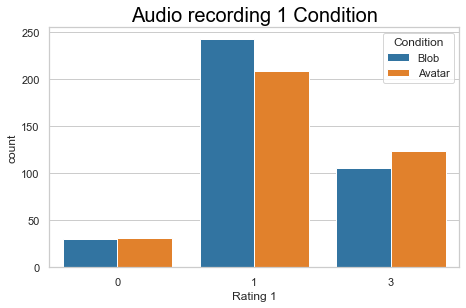

In [184]:
plots_transcription(df_transcription)

In [209]:
df_cleaned_rat_1 = df_transcription.query('rating_1!=0')[['id', 'mode', 'condition', 'rating_1']]
df_cleaned_rat_1

,id,mode,condition,rating_1
0,1,Hybrid,Blob,3
1,1,Hybrid,Blob,3
3,1,Firstperson,Blob,3
4,1,Hybrid,Blob,3
5,1,Hybrid,Blob,3
...,...,...,...,...
767,87,Hybrid,Blob,3
768,87,Firstperson,Blob,3
769,87,Firstperson,Blob,1
770,87,Hybrid,Blob,3


In [210]:
len(df_transcription) - len(df_cleaned_rat_1)

61

In [211]:
df_cleaned_rat_2 = df_transcription.query('rating_2!=0')[['id', 'mode', 'condition', 'rating_2']]
df_cleaned_rat_2

,id,mode,condition,rating_2
0,1,Hybrid,Blob,3
1,1,Hybrid,Blob,3
3,1,Firstperson,Blob,3
4,1,Hybrid,Blob,3
6,1,Hybrid,Blob,3
...,...,...,...,...
766,87,Firstperson,Blob,3
768,87,Firstperson,Blob,3
769,87,Firstperson,Blob,3
770,87,Hybrid,Blob,1


In [212]:
len(df_transcription) - len(df_cleaned_rat_2)

80

In [213]:
df_rat_1 = df_cleaned_rat_1[['condition','mode', 'rating_1']]
df_rat_1

,condition,mode,rating_1
0,Blob,Hybrid,3
1,Blob,Hybrid,3
3,Blob,Firstperson,3
4,Blob,Hybrid,3
5,Blob,Hybrid,3
...,...,...,...
767,Blob,Hybrid,3
768,Blob,Firstperson,3
769,Blob,Firstperson,1
770,Blob,Hybrid,3


In [214]:
df_rat_1_total = (df_rat_1.groupby(['condition','mode'])
                .count()
                .rename(columns={'rating_1' : 'counts'})
                .reset_index())
df_rat_1_total

,condition,mode,counts
0,Avatar,Firstperson,144
1,Avatar,Hybrid,189
2,Blob,Firstperson,176
3,Blob,Hybrid,173


In [215]:
df_rat_2 = df_cleaned_rat_2[['condition','mode', 'rating_2']]
df_rat_2

,condition,mode,rating_2
0,Blob,Hybrid,3
1,Blob,Hybrid,3
3,Blob,Firstperson,3
4,Blob,Hybrid,3
6,Blob,Hybrid,3
...,...,...,...
766,Blob,Firstperson,3
768,Blob,Firstperson,3
769,Blob,Firstperson,3
770,Blob,Hybrid,1


In [216]:
df_rat_2_total = (df_rat_2.groupby(['condition','mode'])
                  .count()
                  .rename(columns={'rating_2' : 'counts'})
                  .reset_index())
df_rat_2_total

,condition,mode,counts
0,Avatar,Firstperson,140
1,Avatar,Hybrid,183
2,Blob,Firstperson,170
3,Blob,Hybrid,170


In [217]:
def max_value_rat_1(df):
    cond = df.condition
    mode = df['mode']
    return (df_rat_1_total
            .query('condition==@cond and mode==@mode')
            .counts
            .values[0])

df_rat_1_prop = df_rat_1.value_counts().reset_index().rename(columns={0 : 'counts'})
df_rat_1_prop['prop_1'] = df_rat_1_prop.counts / df_rat_1_prop.apply(lambda df : max_value_rat_1(df), axis=1)
df_rat_1_prop.drop(columns=['counts'], inplace=True)
df_rat_1_prop

,condition,mode,rating_1,prop_1
0,Blob,Firstperson,1,0.755682
1,Blob,Hybrid,1,0.635838
2,Avatar,Hybrid,1,0.576720
3,Avatar,Firstperson,1,0.694444
4,Avatar,Hybrid,3,0.423280
5,Blob,Hybrid,3,0.364162
6,Avatar,Firstperson,3,0.305556
7,Blob,Firstperson,3,0.244318


In [218]:
def max_value_rat_2(df):
    cond = df.condition
    mode = df['mode']
    return (df_rat_2_total
        .query('condition==@cond and mode==@mode')
        .counts
        .values[0])

df_rat_2_prop = df_rat_2.value_counts().reset_index().rename(columns={0 : 'counts'})
df_rat_2_prop['prop_2'] = df_rat_2_prop.counts / df_rat_2_prop.apply(lambda df : max_value_rat_2(df), axis=1)
df_rat_2_prop.drop(columns=['counts'], inplace=True)
df_rat_2_prop

,condition,mode,rating_2,prop_2
0,Blob,Firstperson,1,0.735294
1,Avatar,Hybrid,1,0.677596
2,Blob,Hybrid,1,0.705882
3,Avatar,Firstperson,1,0.700000
4,Avatar,Hybrid,3,0.322404
5,Blob,Hybrid,3,0.294118
6,Blob,Firstperson,3,0.264706
7,Avatar,Firstperson,3,0.300000


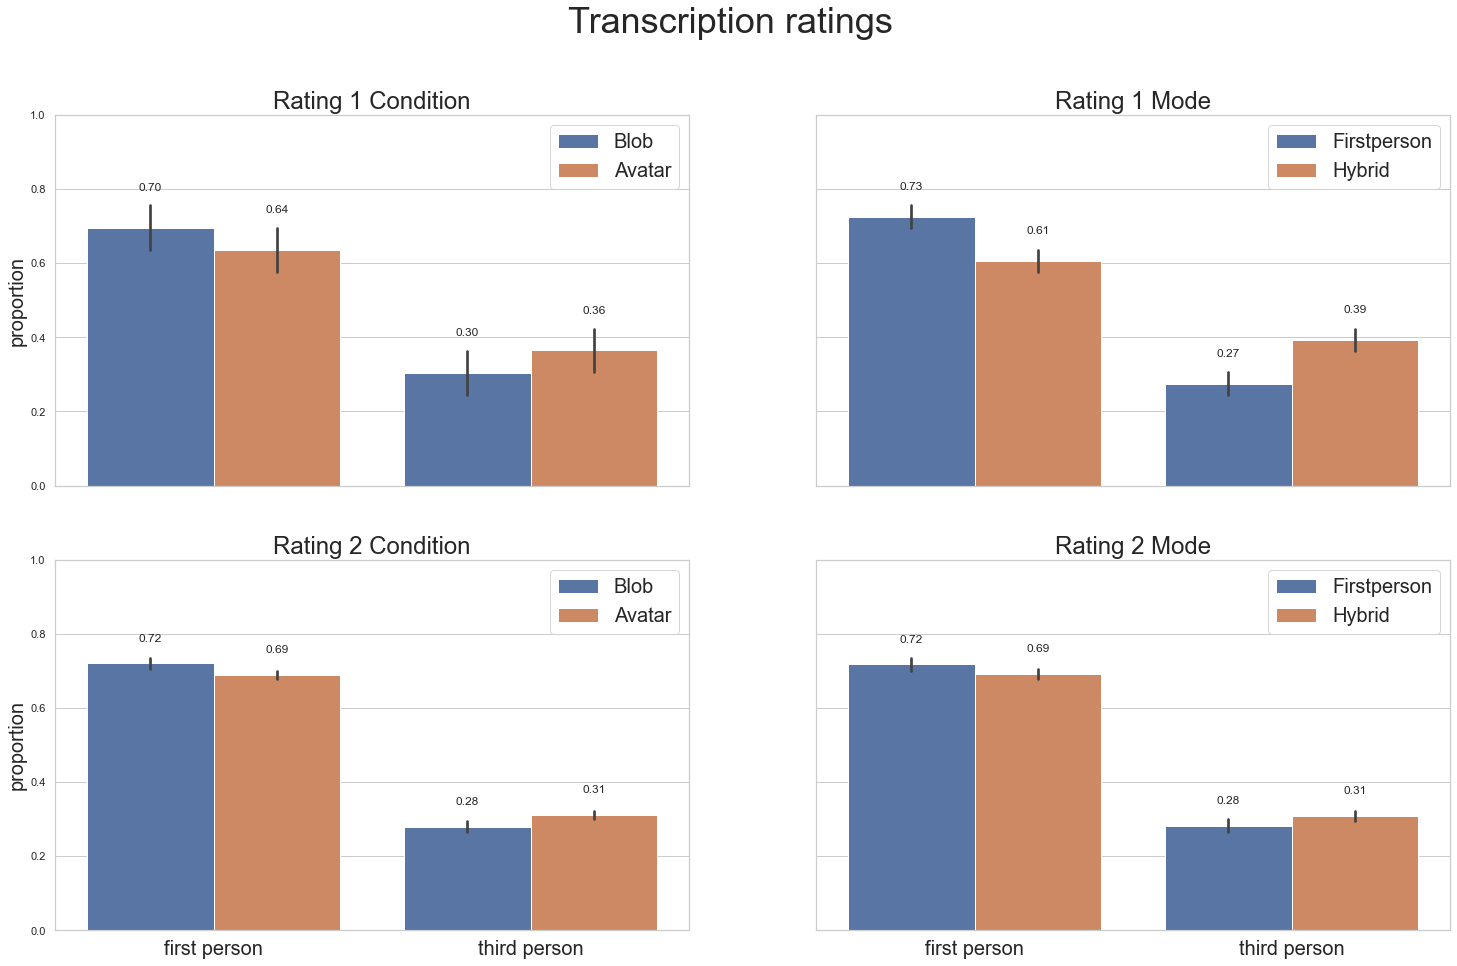

In [248]:
fig, axes = plt.subplots(2, 2, figsize=(25,15), sharex=True, sharey=True)

p1 = sns.barplot(
    data=df_rat_1_prop,
    x='rating_1',
    y='prop_1',
    hue='condition',
    ci=95,
    ax=axes[0,0])

for p in p1.patches:
    p1.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 40), textcoords = 'offset points')

axes[0,0].set_title('Rating 1 Condition', size=24)

p2 = sns.barplot(
    data=df_rat_1_prop,
    x='rating_1',
    y='prop_1',
    hue='mode',
    ci=95,
    ax=axes[0,1])

for p in p2.patches:
    p2.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 30), textcoords = 'offset points')

axes[0,1].set_title('Rating 1 Mode', size=24)

p3 = sns.barplot(
    data=df_rat_2_prop,
    x='rating_2',
    y='prop_2',
    hue='condition',
    ci=95,
    ax=axes[1,0])

for p in p3.patches:
    p3.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 25), textcoords = 'offset points')

axes[1,0].set_title('Rating 2 Condition', size=24)


p4 = sns.barplot(
    data=df_rat_2_prop,
    x='rating_2',
    y='prop_2',
    hue='mode',
    ci=95,
    ax=axes[1,1])

for p in p4.patches:
    p4.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 25), textcoords = 'offset points')

axes[1,1].set_title('Rating 2 Mode', size=24)

plt.setp(axes, ylim=(0,1), xlabel='', ylabel='')
axes[0,0].set_ylabel('proportion', fontsize=20)
axes[0,0].legend(fontsize=20)

axes[0,1].legend(fontsize=20)

axes[1,0].set_ylabel('proportion', fontsize=20)
axes[1,0].legend(fontsize=20)
axes[1,0].set_xticklabels(['first person', 'third person'], fontsize=20)

axes[1,1].legend(fontsize=20)
axes[1,1].set_xticklabels(['first person', 'third person'], fontsize=20)

plt.suptitle('Transcription ratings', size=36)

plt.show()

### Assumptions check and Anova (without zeros)

Rating 1

In [220]:
check_assumptions(df_cleaned_rat_1,'rating_1','rating_1')

Checking the assumptions for the dependent variable rating_1...

The residuals are NOT approximately normally distributed for each level of the within-subjects factor! (tested using the Shapiro-Wilks Test)

There should be equal variance for every level of within-subject factor:
For the level Hybrid, Levene's test resulted in a p-value of 0.252, indicating that the assumption of equal variances is True.
For the level First Person, Levene's test resulted in a p-value of 0.222, indicating that the assumption of equal variances is True.

Mauchly’s test of sphericity resulted in a p-value of 1.0, indicating that the assumption is True.

The homogeneity of variance-covariance matrices formed by the between-subject factor for each level of the within-subject factor should be equal:
For the level First Person, Box’s M test resulted in a p-value of 0.378, indicating that the assumption is True.
For the level Hybrid, Box’s M test resulted in a p-value of 0.726, indicating that the assumption is

In [221]:
aov = pg.mixed_anova(dv='rating_1', within='mode', between='condition', subject='id', data=df_cleaned_rat_1)
# Pretty printing of ANOVA summary
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------  -----  -----  -----  -----  ------  -------  -----  -------
condition    0.811      1     79  0.811   0.905    0.344  0.011  nan
mode         2.090      1     79  2.090  11.081    0.001  0.123    1.000
Interaction  0.031      1     79  0.031   0.166    0.685  0.002  nan



Rating 2

In [222]:
check_assumptions(df_transcription,'rating_2','rating_2')

Checking the assumptions for the dependent variable rating_2...

The residuals are NOT approximately normally distributed for each level of the within-subjects factor! (tested using the Shapiro-Wilks Test)

There should be equal variance for every level of within-subject factor:
For the level Hybrid, Levene's test resulted in a p-value of 0.576, indicating that the assumption of equal variances is True.
For the level First Person, Levene's test resulted in a p-value of 0.426, indicating that the assumption of equal variances is True.

Mauchly’s test of sphericity resulted in a p-value of 1.0, indicating that the assumption is True.

The homogeneity of variance-covariance matrices formed by the between-subject factor for each level of the within-subject factor should be equal:
For the level First Person, Box’s M test resulted in a p-value of 0.476, indicating that the assumption is True.
For the level Hybrid, Box’s M test resulted in a p-value of 0.714, indicating that the assumption is

In [223]:
aov = pg.mixed_anova(dv='rating_2', within='mode', between='condition', subject='id', data=df_cleaned_rat_2)
# Pretty printing of ANOVA summary
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
condition    0.233      1     78  0.233  0.354    0.554  0.005  nan
mode         0.004      1     78  0.004  0.019    0.890  0.000    1.000
Interaction  0.015      1     78  0.015  0.078    0.781  0.001  nan



### Assumptions check and Anova

#### Rating_1

In [104]:
check_assumptions(df_transcription,'rating_1','rating_1')

Checking the assumptions for the dependent variable rating_1...

The residuals are NOT approximately normally distributed for each level of the within-subjects factor! (tested using the Shapiro-Wilks Test)

There should be equal variance for every level of within-subject factor:
For the level Hybrid, Levene's test resulted in a p-value of 0.267, indicating that the assumption of equal variances is True.
For the level First Person, Levene's test resulted in a p-value of 0.173, indicating that the assumption of equal variances is True.

Mauchly’s test of sphericity resulted in a p-value of 1.0, indicating that the assumption is True.

The homogeneity of variance-covariance matrices formed by the between-subject factor for each level of the within-subject factor should be equal:
For the level First Person, Box’s M test resulted in a p-value of 0.223, indicating that the assumption is True.
For the level Hybrid, Box’s M test resulted in a p-value of 0.76, indicating that the assumption is 

In [105]:
aov = pg.mixed_anova(dv='rating_1', within='mode', between='condition', subject='id', data=df_transcription)
# Pretty printing of ANOVA summary
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
condition    0.427      1     79  0.427  0.627    0.431  0.008  nan
mode         2.155      1     79  2.155  9.910    0.002  0.111    1.000
Interaction  0.070      1     79  0.070  0.321    0.573  0.004  nan



#### Rating_2

In [106]:
check_assumptions(df_transcription,'rating_2','rating_2')

Checking the assumptions for the dependent variable rating_2...

The residuals are NOT approximately normally distributed for each level of the within-subjects factor! (tested using the Shapiro-Wilks Test)

There should be equal variance for every level of within-subject factor:
For the level Hybrid, Levene's test resulted in a p-value of 0.576, indicating that the assumption of equal variances is True.
For the level First Person, Levene's test resulted in a p-value of 0.426, indicating that the assumption of equal variances is True.

Mauchly’s test of sphericity resulted in a p-value of 1.0, indicating that the assumption is True.

The homogeneity of variance-covariance matrices formed by the between-subject factor for each level of the within-subject factor should be equal:
For the level First Person, Box’s M test resulted in a p-value of 0.476, indicating that the assumption is True.
For the level Hybrid, Box’s M test resulted in a p-value of 0.714, indicating that the assumption is

In [107]:
aov = pg.mixed_anova(dv='rating_2', within='mode', between='condition', subject='id', data=df_transcription)
# Pretty printing of ANOVA summary
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
condition    0.058      1     79  0.058  0.112    0.739  0.001  nan
mode         0.173      1     79  0.173  0.966    0.329  0.012    1.000
Interaction  0.008      1     79  0.008  0.042    0.838  0.001  nan

